In [3]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
import numpy as np
import math
import pandas
from matplotlib import pyplot as plt
from PIL import Image
import os


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
locloc = "PreparedNp" 
namename = "\Cube"
all_photos = np.load(locloc + namename + 'Photos.npy')
all_labels = np.load(locloc + namename + 'Labels.npy') # Эта штука соответствует одному из значений в all_degrees, котрое соответствует некой маске
#all_vectors = np.load(locloc + namename + 'Vectors.npy')
all_degrees = np.load(locloc + namename + 'RotationDegrees.npy')
#all_albedos = np.load(locloc + namename + 'Albedos.npy')
all_normals = np.load(locloc + namename + 'Normals.npy')
#all_masks = np.load(locloc + namename + 'Masks.npy')
# Цель просто сделать рабочий генератор маски.

In [5]:
def masstest(mylist):
    numlist = mylist 
    intotheflames = list()
    testanswers = list()
    
    intotheflames.append(all_photos[numlist])
    testanswers.append(answerList[numlist])
    
    intotheflames = np.array(intotheflames)[0]
    testanswers = np.array(testanswers)[0]
    print(intotheflames.shape)
    imgimg = model.predict(intotheflames)
    r0 =  np.concatenate(np.take(intotheflames, [0,1,2,3], axis=0), axis=0)
    r1 =  np.concatenate(np.take(imgimg, [0,1,2,3], axis=0), axis=0)
    r2 =  np.concatenate(np.take(testanswers, [0,1,2,3], axis=0), axis=0)
    r3 =  np.concatenate(np.take(intotheflames, [4,5,6,7], axis=0), axis=0)
    r4 =  np.concatenate(np.take(imgimg, [4,5,6,7], axis=0), axis=0)
    r5 =  np.concatenate(np.take(testanswers, [4,5,6,7], axis=0), axis=0)
    finalimage = np.concatenate([r0,r1,r2,r3,r4, r5], axis=1)
    return finalimage

In [8]:
batch_size = 64
train_size = int(0.95 * len(all_photos)) # SMALL DATASET FOR TESTING

dictDegrees = dict()
for i in range(len(all_degrees)):
    dictDegrees[all_degrees[i]] = all_normals[i]

answerList = list()
for i in range(len(all_photos)):
    answerList.append(dictDegrees[all_labels[i]])
answerList = np.array(answerList)

dataset = tf.data.Dataset.from_tensor_slices((all_photos, answerList))
dataset = dataset.shuffle(buffer_size=512, seed=42)

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

train_dataset = train_dataset.batch(64, drop_remainder=True)
test_dataset = test_dataset.batch(64,drop_remainder=True)

114 6


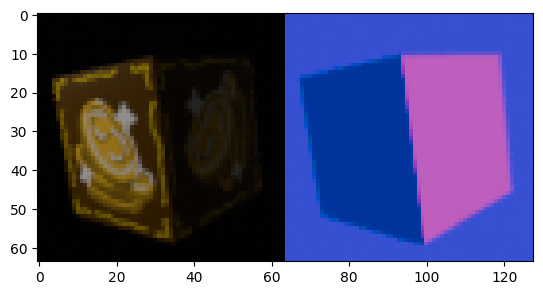

In [9]:
print(len(list(train_dataset)), len(list(test_dataset)))
imtoshownum = 2000
imtoshow = np.concatenate( [all_photos[imtoshownum], answerList[imtoshownum]], axis=1).astype("float32")
plt.imshow(imtoshow)

In [23]:
def build_unet(input_shape=(64, 64, 3)):
    inputs = keras.layers.Input(shape=input_shape)

    # Экстрактор (кодировщик)
    e1 = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    e2 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(e1)
    e3 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(e2)
    e4 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(e3)
    e5 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(e4)

    dropout = keras.layers.Dropout(0.2)(e5)
    # Декодер (генератор)
    d0 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(dropout)
    d1 = keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(keras.layers.Concatenate()([d0, e4]))
    d2 = keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(keras.layers.Concatenate()([d1, e3]))
    d3 = keras.layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(keras.layers.Concatenate()([d2, e2]))
    d4 = keras.layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(keras.layers.Concatenate()([d3, e1]))

    model = keras.models.Model(inputs=inputs, outputs=d4)

    return model

In [24]:
g_optimizer_image=keras.optimizers.Adam(learning_rate=0.000025)

In [33]:
model = build_unet()
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)
model.summary()
model.compile(optimizer=g_optimizer_image, loss='mean_squared_error', metrics=[psnr])

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_24 (Conv2D)             (None, 64, 64, 16)   448         ['input_5[0][0]']                
                                                                                                  
 conv2d_25 (Conv2D)             (None, 64, 64, 32)   4640        ['conv2d_24[0][0]']              
                                                                                                  
 conv2d_26 (Conv2D)             (None, 64, 64, 64)   18496       ['conv2d_25[0][0]']              
                                                                                            

In [34]:
model.fit(train_dataset, epochs=1)

114/114 [==============================] - 23s 193ms/step - loss: 0.0352 - psnr: 15.2360


toinset = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500]
bigpicture = masstest(toinset)
print(bigpicture.shape)
plt.imshow(bigpicture.astype("float32"))

(8, 64, 64, 3)
1/1 [==============================] - 0s 38ms/step
(256, 384, 3)


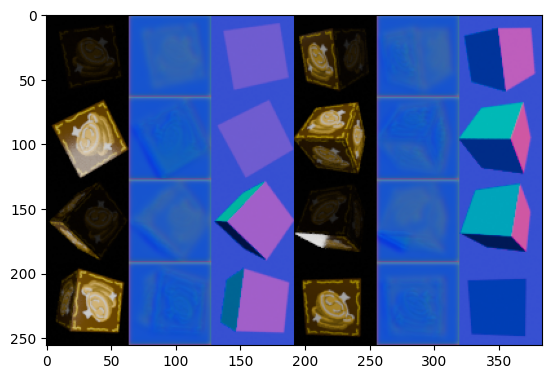

In [36]:
toinset = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500]
bigpicture = masstest(toinset)
print(bigpicture.shape)
plt.imshow(bigpicture.astype("float32"))

In [31]:
model.save("PoorNormals002.keras")